In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

##import lightgbm as lgb
##from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

SEED = 2
np.random.seed(SEED)

In [3]:
# renaming columns
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [4]:
train= pd.read_csv('~/Desktop/energy/train.csv', encoding = 'cp949',  names=train_col, header=0)
test = pd.read_csv('~/Desktop/energy/test.csv', encoding = 'cp949', names=test_col, header=0)
sub = pd.read_csv('~/Desktop/energy/sample_submission.csv', encoding='cp949')

In [5]:
train_df = train.copy()

In [6]:
## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
# THI : 기온, 습도로 불쾌지수 계산 [1.8*기온 -0.55*(1-습도)*(1.8*기온-26)+32]
# - 쾌적/다소 불쾌/불쾌/ 매우 불쾌 [0, 68, 75, 80, 200] ?
train_df['THI'] = 9/5*train_df['temp'] - 0.55*(1-train_df['humid']/100)*(9/5*train_df['humid']-26)+32

In [7]:
train_df.head()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,THI
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,57.5376
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,57.0389
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,56.6789
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,55.9589
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,56.4576


In [8]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

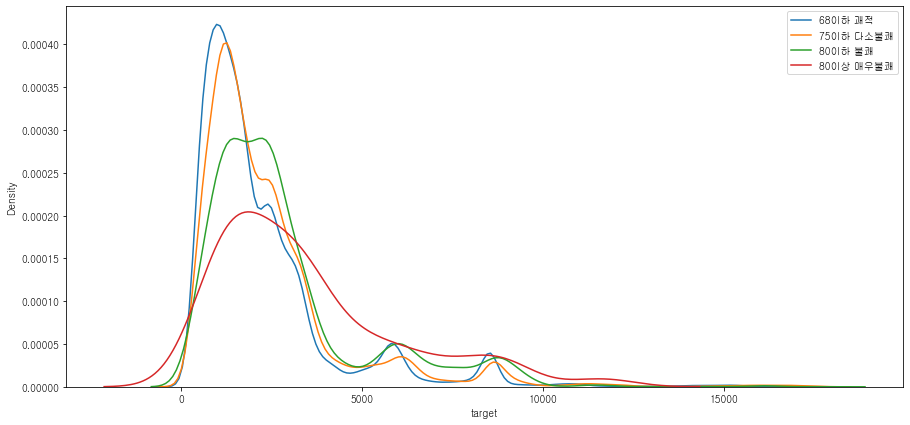

In [9]:
# 불괘지수에 따른 전력사용량의 histogram  : KDE (커널밀도추정) → kdeplot 사용

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.kdeplot(train_df[train_df['THI'] <=68 ]['target'], ax=ax)
sns.kdeplot(train_df[(train_df['THI'] >68) & (train_df['THI'] <=75)]['target'], ax=ax)
sns.kdeplot(train_df[(train_df['THI'] >75) & (train_df['THI'] <=80)]['target'], ax=ax)
sns.kdeplot(train_df[train_df['THI'] >80]['target'], ax=ax)
plt.legend(['68이하 괘적', '75이하 다소불쾌', '80이하 불쾌','80이상 매우불쾌'])
plt.show()

In [10]:
train_1 = train_df[train_df.num == 1]
train_1.shape

(2040, 11)

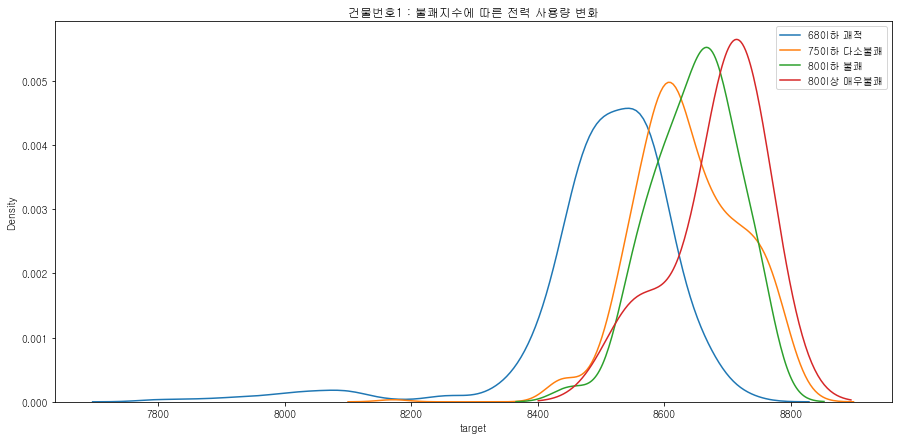

In [11]:
# 건물번호 1번 불괘지수에 따른 전력사용량의 histogram  : KDE (커널밀도추정) → kdeplot 사용

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.kdeplot(train_1[train_1['THI'] <=68 ]['target'], ax=ax)
sns.kdeplot(train_1[(train_1['THI'] >68) & (train_1['THI'] <=75)]['target'], ax=ax)
sns.kdeplot(train_1[(train_1['THI'] >75) & (train_1['THI'] <=80)]['target'], ax=ax)
sns.kdeplot(train_1[train_1['THI'] >80]['target'], ax=ax)
plt.legend(['68이하 괘적', '75이하 다소불쾌', '80이하 불쾌','80이상 매우불쾌'])
plt.title("건물번호1 : 불쾌지수에 따른 전력 사용량 변화")
plt.show()

* 불쾌지수가 높을수록 전력사용량 증가 함. (건물별로 확인 시 더 분명해 보임)

<AxesSubplot:xlabel='sunny', ylabel='target'>

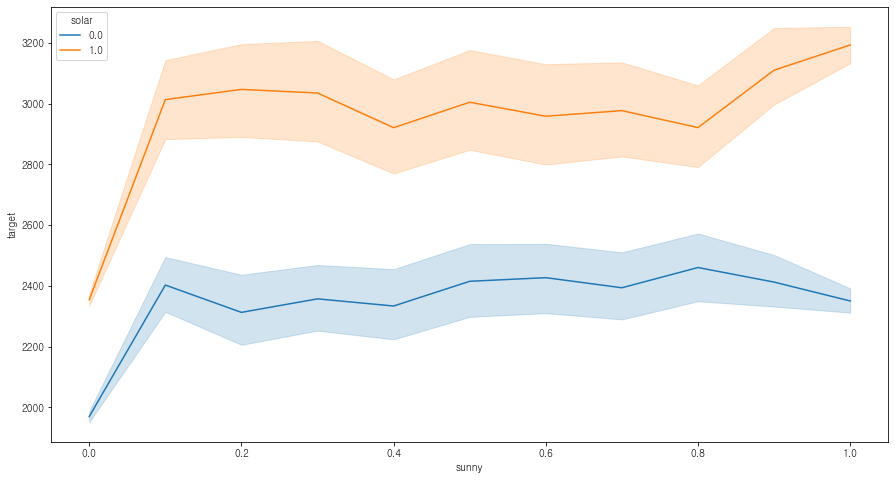

In [12]:
# 태양광 설치 여부에 따른 일조량과 전력사용량 비교
plt.figure(figsize = (15,8))
sns.lineplot(x = 'sunny', y = 'target', hue = 'solar', data = train_df)

* 태양광이 설치된 건물은 일조량에 따라 전력소비량에 음의 영향이 있을 것이라 생각했지만 건물별 전력소비량이 차이가 커 유의미하게 보이지 않음.

<AxesSubplot:xlabel='temp', ylabel='target'>

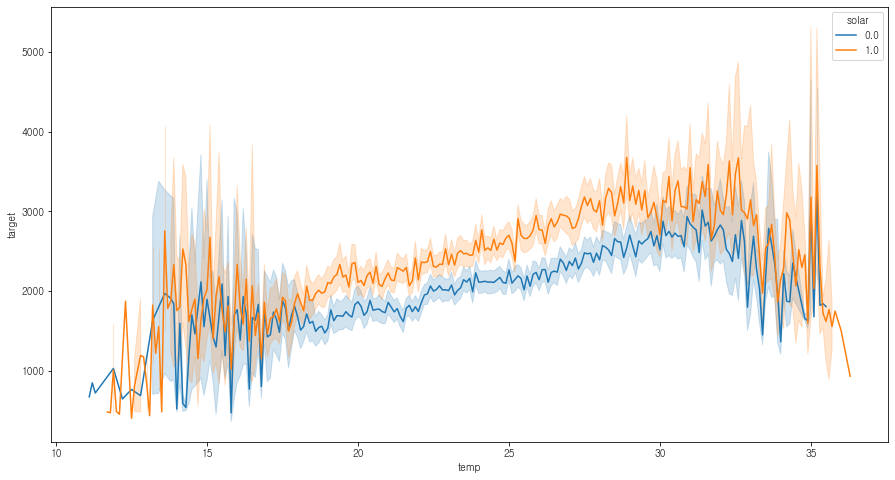

In [13]:
# 태양광 설치 여부에 따른 기온과 전력사용량 비교
plt.figure(figsize = (15,8))
sns.lineplot(x = 'temp', y = 'target', hue = 'solar', data = train_df)

* 기온에 따른 전력소비량이 고온과 저온에서 늘어나는 것을 볼 수 있으나 태양광 보유 여부에 의한 것으로 비교하기엔 건물별 특징이 너무 다름.

<AxesSubplot:xlabel='temp', ylabel='target'>

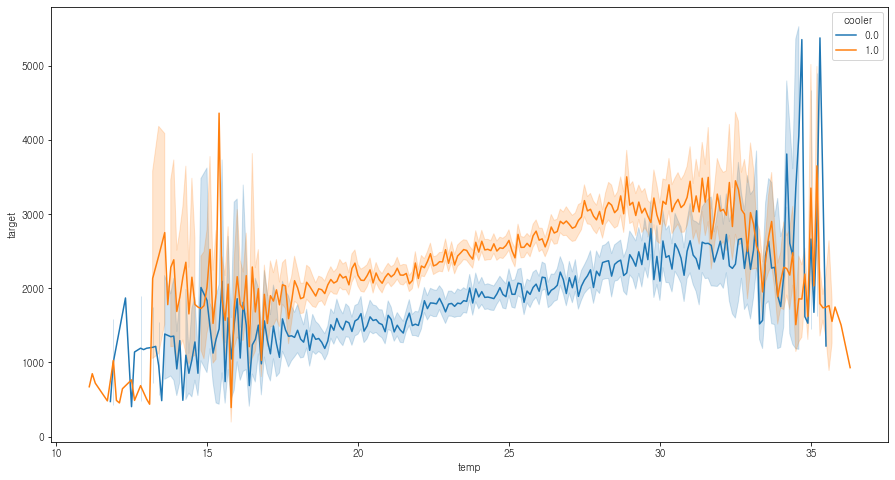

In [14]:
# 비전기냉방설비 운영 여부에 따른 기온과 전력사용량 비교
plt.figure(figsize = (15,8))
sns.lineplot(x = 'temp', y = 'target', hue = 'cooler', data = train_df)

* 비전기냉방설비 운영 여부로 기온에 따른 전력소비량 변화를 보는것은 태양광 보유 여부와 마찬가지임.

In [15]:
heatmap_data = train_df[['target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar', 'THI']] 
heatmap_data.corr() # 상관관계 계산

,target,temp,wind,humid,rain,sunny,cooler,solar,THI
target,1.000000,0.158361,0.109965,-0.077199,-0.006028,0.112131,0.150799,0.116344,0.089470
temp,0.158361,1.000000,0.167455,-0.509105,-0.093788,0.515657,0.019067,0.025865,0.560367
wind,0.109965,0.167455,1.000000,-0.110439,0.083433,0.156381,0.006275,-0.076560,0.065033
humid,-0.077199,-0.509105,-0.110439,1.000000,0.208862,-0.627597,-0.031405,-0.020657,0.325783
rain,-0.006028,-0.093788,0.083433,0.208862,1.000000,-0.112646,-0.003560,-0.016685,0.155578
sunny,0.112131,0.515657,0.156381,-0.627597,-0.112646,1.000000,-0.005695,-0.008412,0.006842
cooler,0.150799,0.019067,0.006275,-0.031405,-0.003560,-0.005695,1.000000,0.084842,-0.009674
solar,0.116344,0.025865,-0.076560,-0.020657,-0.016685,-0.008412,0.084842,1.000000,0.013759
THI,0.089470,0.560367,0.065033,0.325783,0.155578,0.006842,-0.009674,0.013759,1.000000


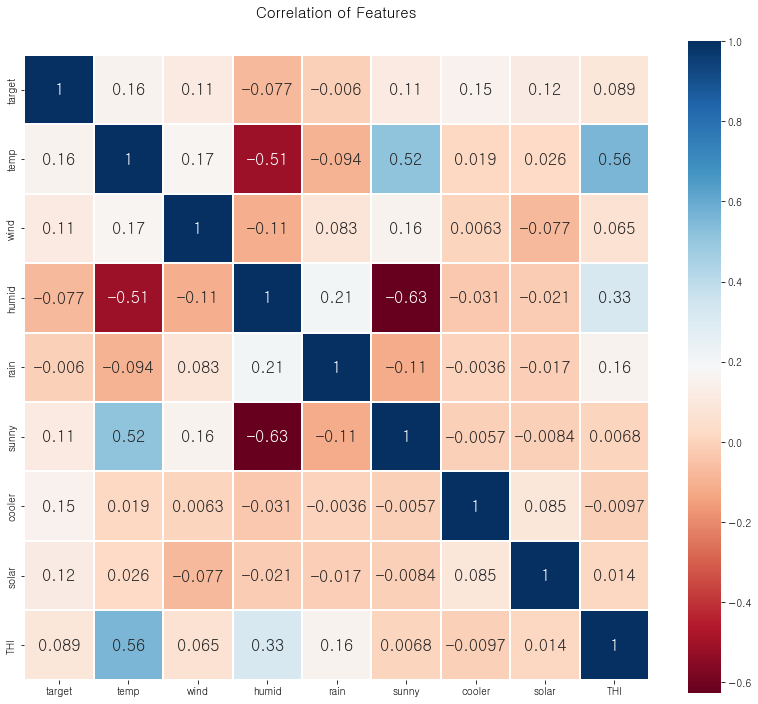

In [16]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})
# vmax=1.0(색변환), linewidths=0.1(칸사이의 선), annot=True(수치 보기)


del heatmap_data

온도(temp), 일조량(sunny)은 양의 상관관계를, 습도(humid), 강수량(rain)과는 음의 상관관계를 가짐.<br>
당연히 불쾌지수(THI)엔 온도(temp)와 습도(humid) 상관관계가 있음을 확인.

* 전력사용량(target)에 유의미한 상관관계 확인을 위한 전처리 과정이 더 필요 해 보임.

In [17]:
def make_time(train):
    """
    시간 관련 변수를 추가하기 위한 함수
    """
    train['date_time'] = pd.to_datetime(train.date_time)
    
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 요일(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    
    return train

In [18]:

train = make_time(train)
test = make_time(test)

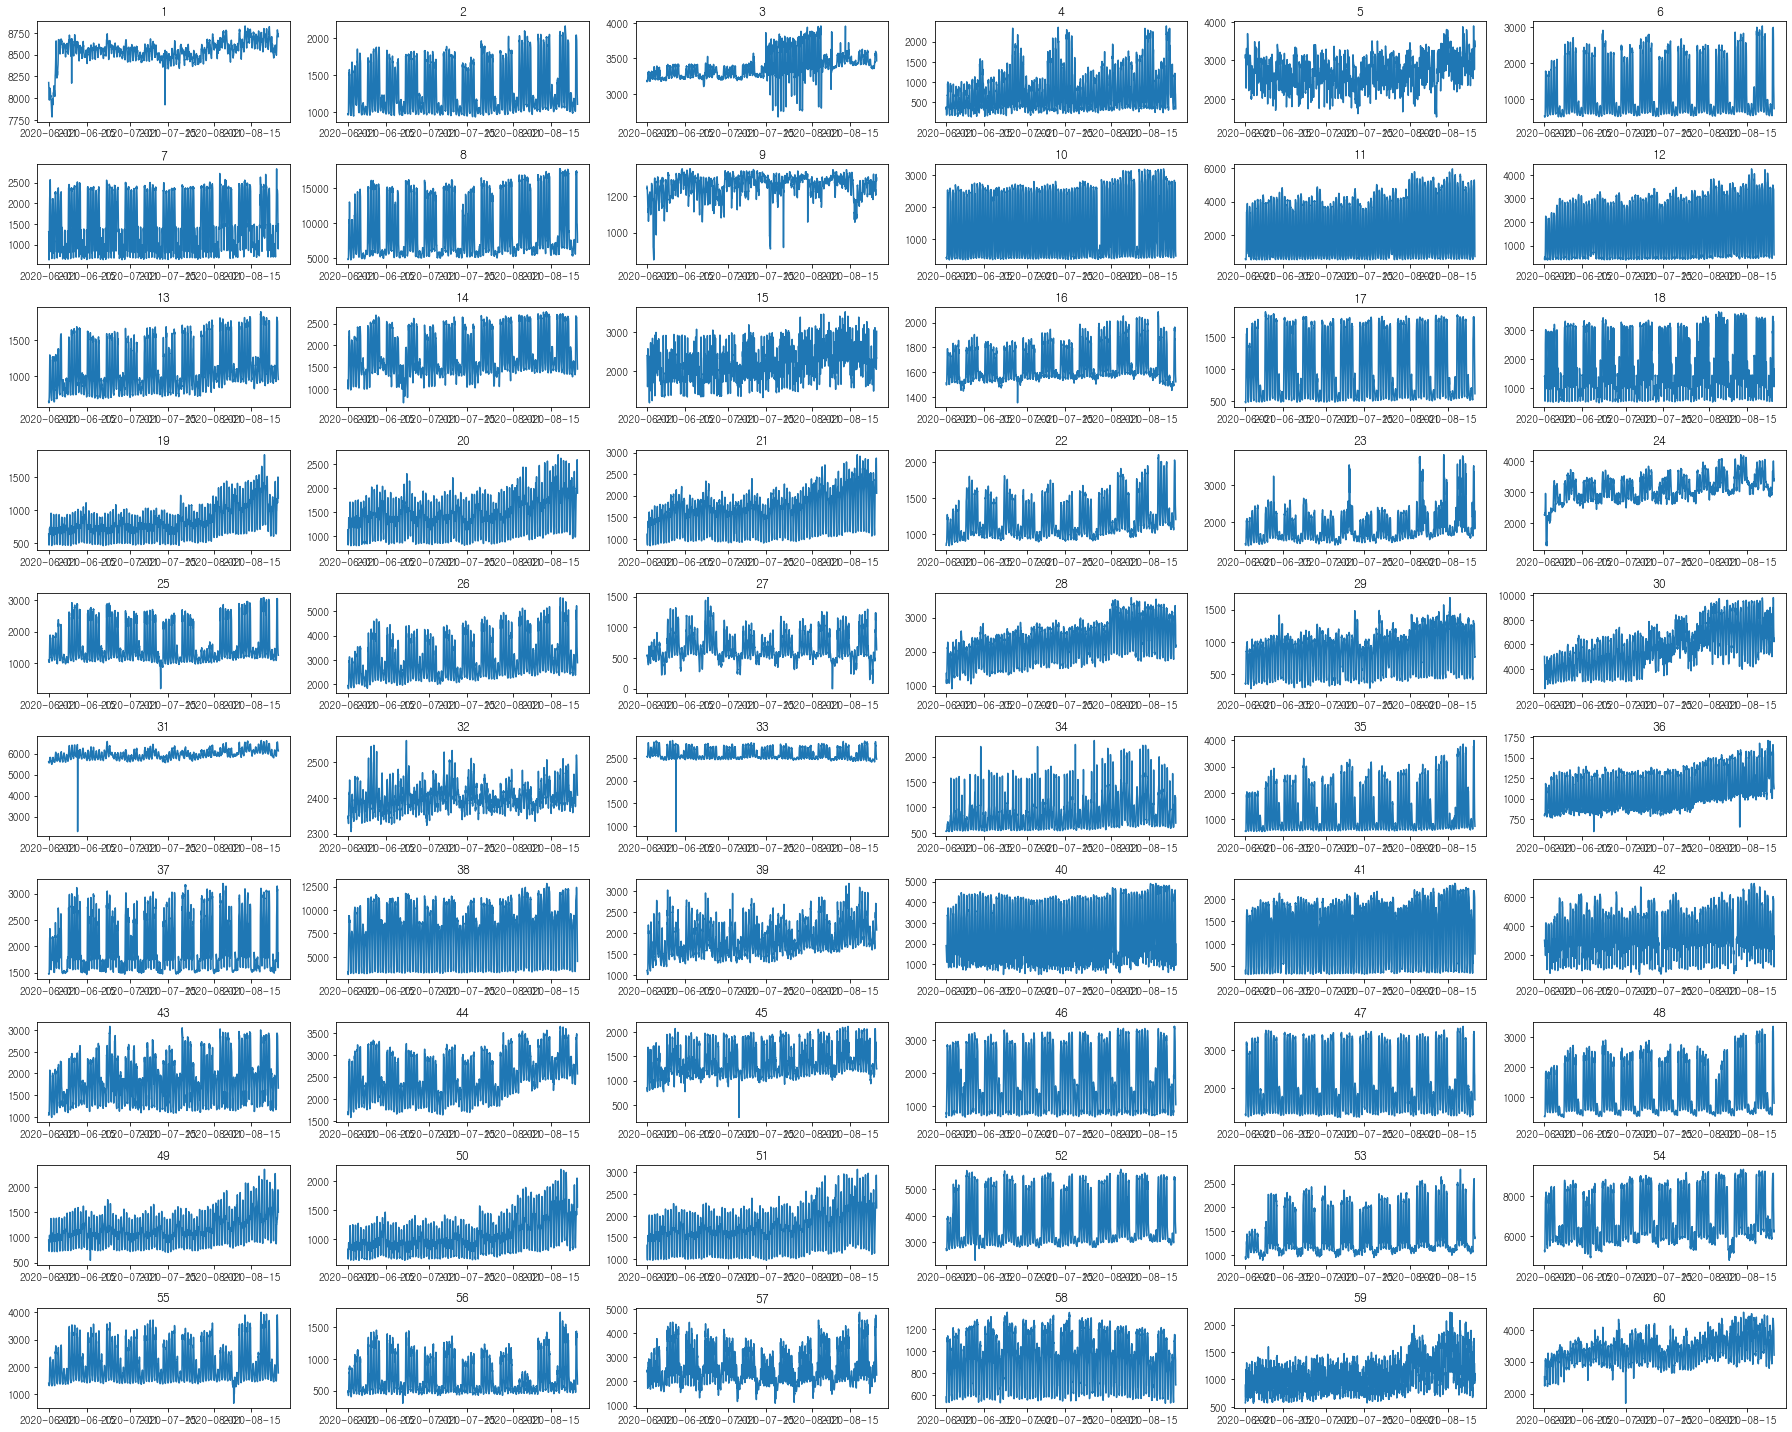

In [19]:
## 건물별로 시간에 따라서 전력사용량 시각화 시켜보기

plt.figure(figsize=(25, 20))

for i, j in enumerate(train['num'].unique().tolist()):
    ax = plt.subplot2grid((10, 6), (i//6, i%6))
    ax.plot(train.loc[train['num'] == j]['date_time'], train.loc[train['num'] == j]['target'])
    ax.set_title(j)
    
plt.tight_layout()
plt.show()

In [20]:

train.loc[train.weekday >= 5, 'holiday'] = 1
train.loc[train.weekday < 5, 'holiday'] = 0
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = 1

test.loc[test.weekday >= 5, 'holiday'] = 1
test.loc[test.weekday < 5, 'holiday'] = 0

In [21]:
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

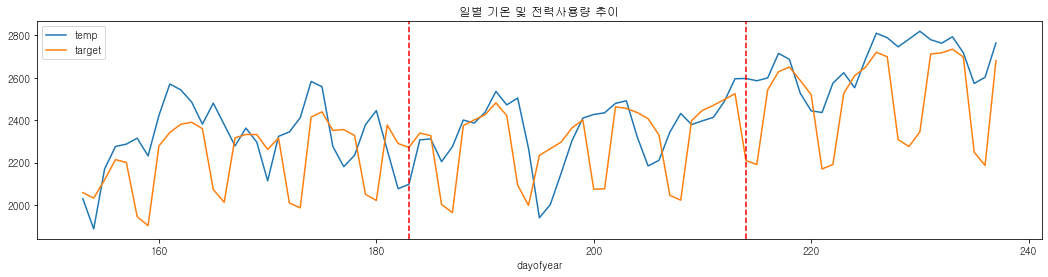

In [22]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('일별 기온 및 전력사용량 추이')
plt.show()

In [23]:
train.head()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,153,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,153,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,153,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,153,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,153,0.0


In [24]:
test.head()

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,0.0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,1,1,238,0.0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,2,1,238,0.0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,0.0,0.0,8,25,3,1,238,0.0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,4,1,238,0.0


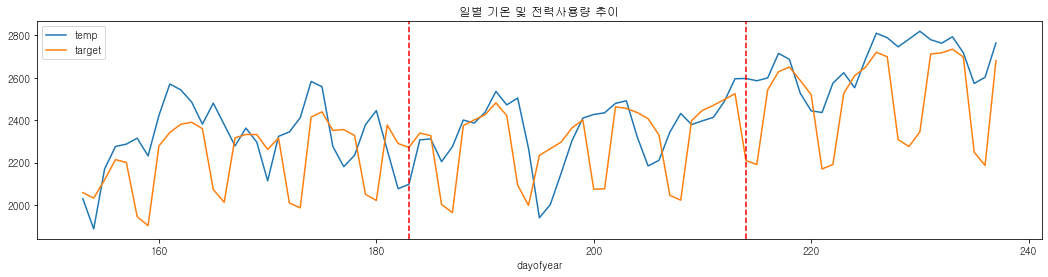

In [25]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('일별 기온 및 전력사용량 추이')
plt.show()

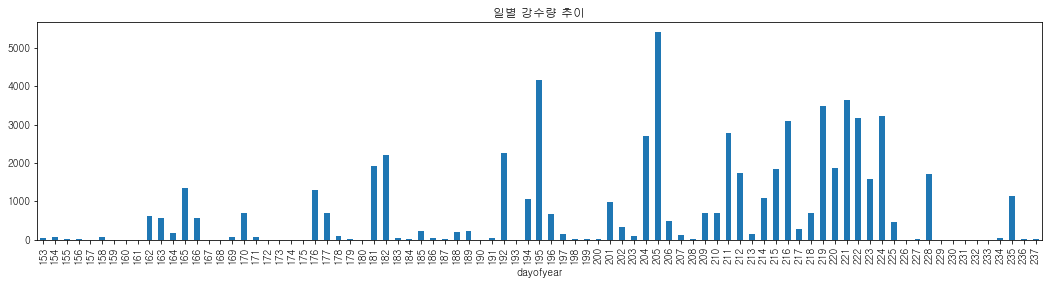

In [26]:
(train.groupby(['dayofyear'])['rain'].sum()).plot(kind='bar', figsize=(18, 4))
plt.title('일별 강수량 추이')
plt.show()

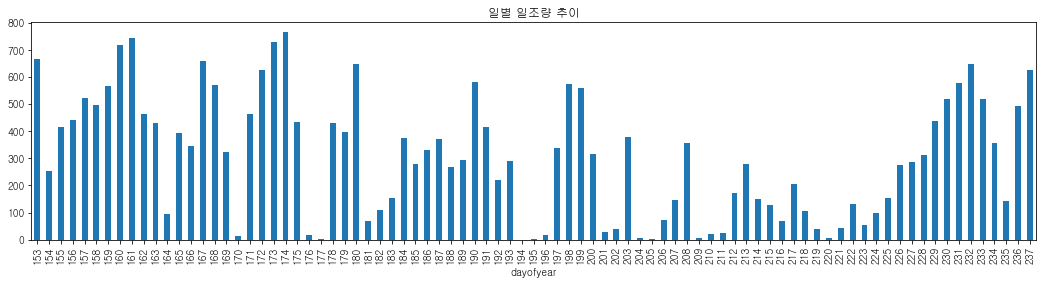

In [27]:
train.groupby(['dayofyear'])['sunny'].sum().plot(kind='bar', figsize=(18, 4))
plt.title('일별 일조량 추이')
plt.show()

In [28]:
train_origin = train.copy()

In [29]:
for i in range(1, 61):
    mean_ = train.loc[train.num == i].target.mean()
    std_ = train.loc[train.num == i].target.std()
    train.loc[train.num == i, 'target'] = ((train.loc[train.num == i, 'target']) - mean_) / std_

In [30]:
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [31]:
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [32]:
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [33]:
columns = (
    ['num']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
)

cl_df.columns = columns

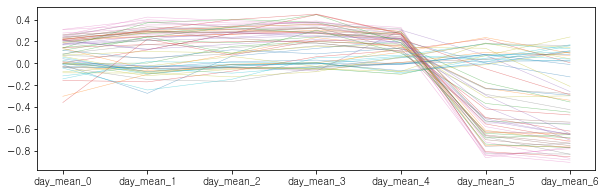

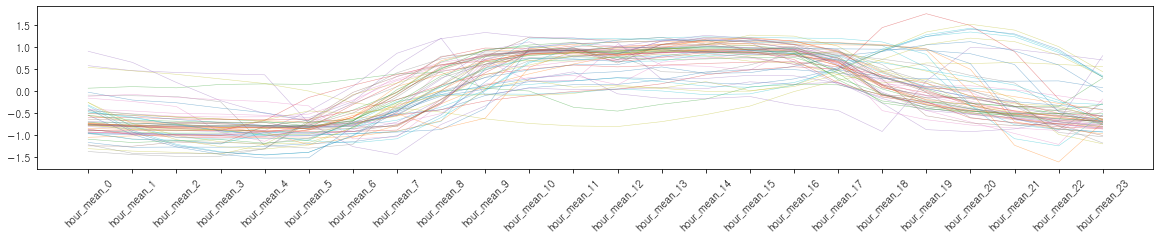

In [34]:
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)
    plt.xticks(rotation=45)

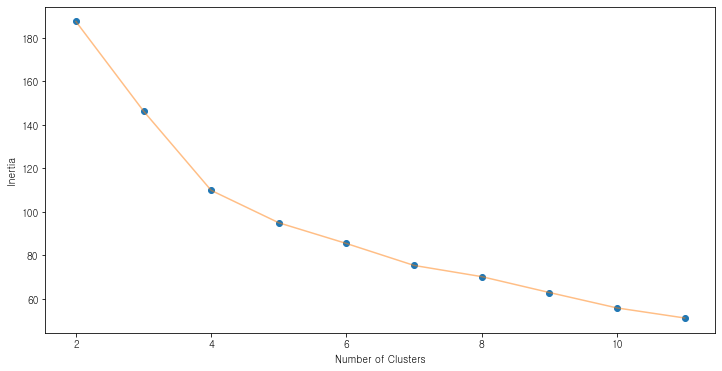

In [35]:
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

In [36]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [37]:
cl_df['km_cluster'] = pred

In [38]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [39]:
test_cl = test.copy()

In [40]:
for i in range(1, 61):
    test_cl.loc[test_cl.num == i, 'km_cluster'] = (
        train_cl.loc[train_cl.num == i, 'km_cluster'].max()
    )

In [41]:
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

In [42]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040

,num
km_cluster,
0,7.0
1,33.0
2,5.0
3,15.0


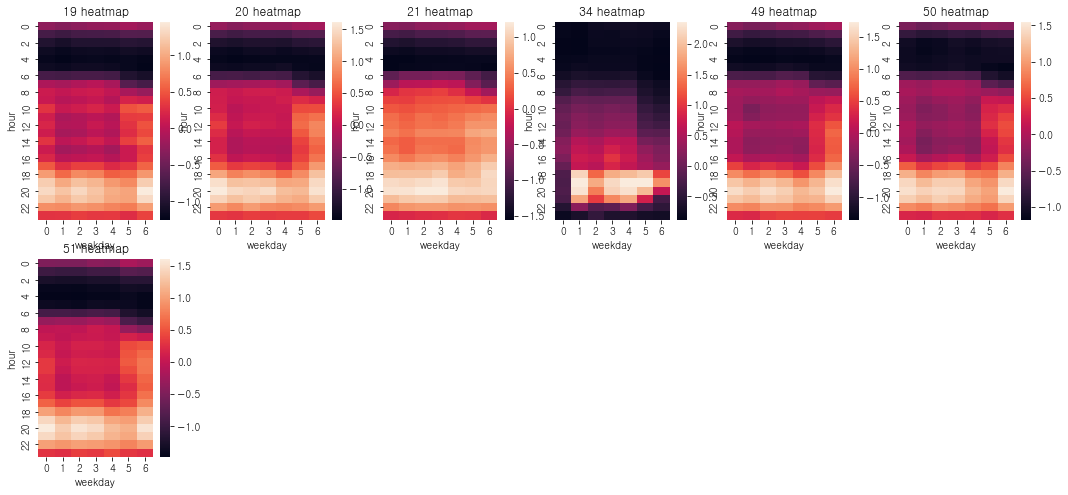

In [43]:
fig = plt.figure(figsize=(18, np.ceil(len(km_0)/6)*4))
for i, n in enumerate(km_0):
    plt.subplot(np.ceil(len(km_0)/6), 6, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

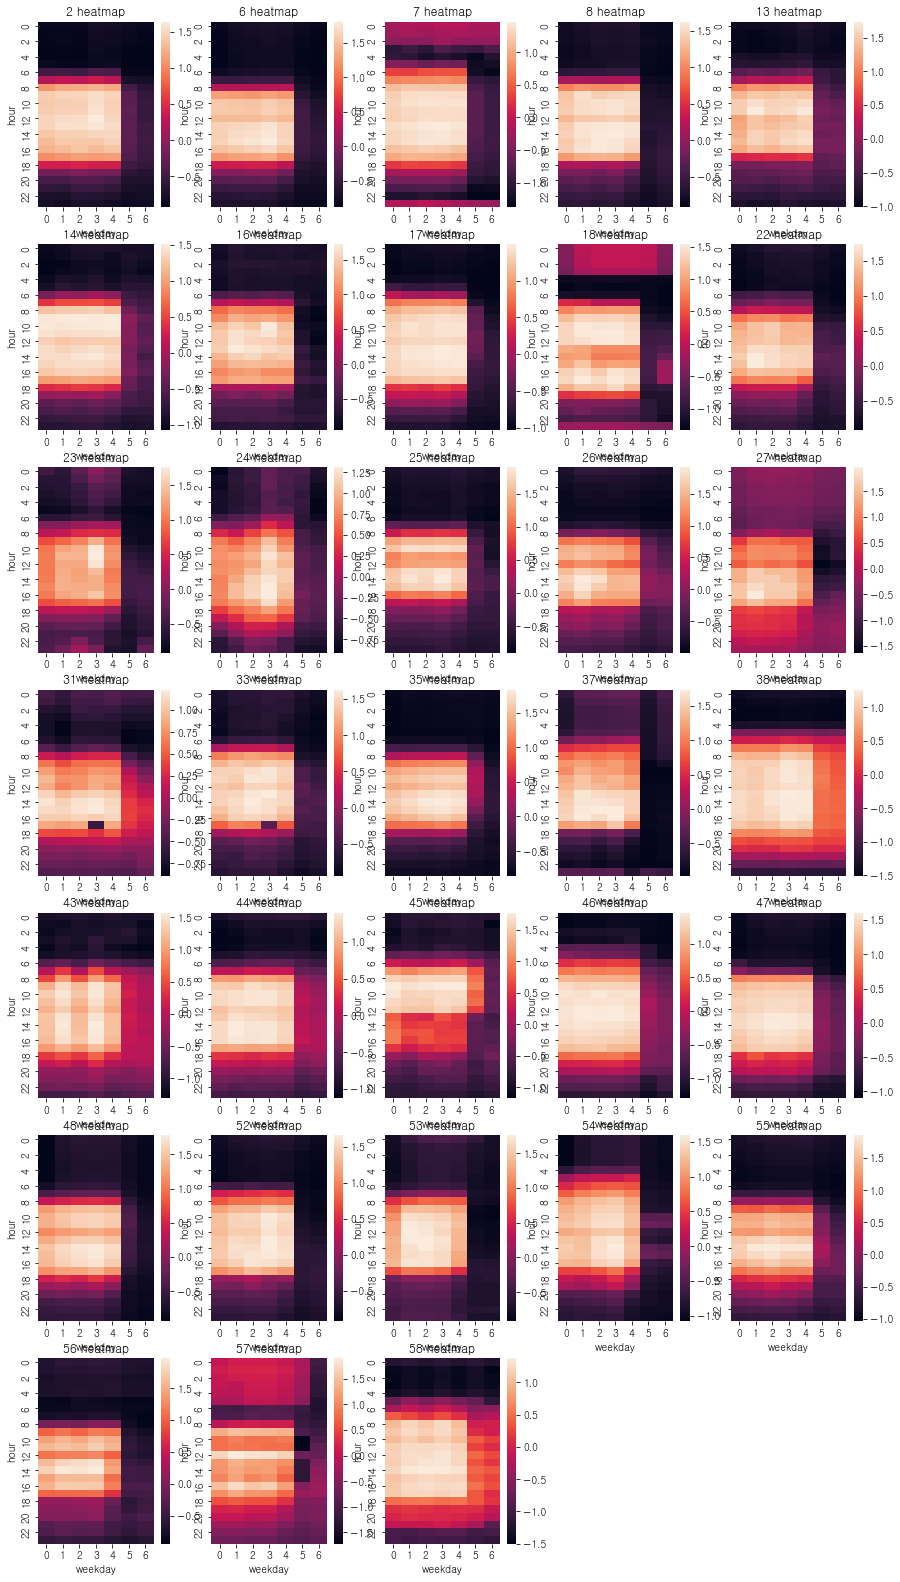

In [44]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

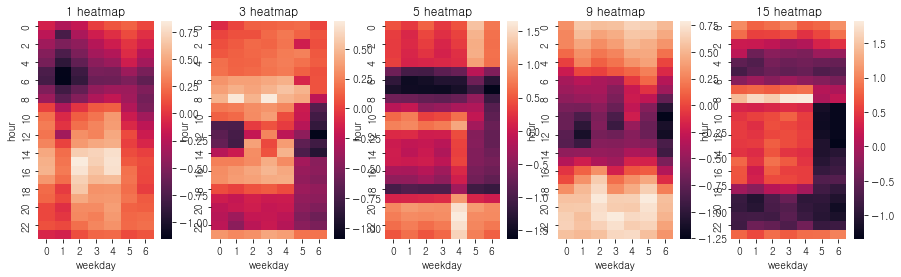

In [45]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

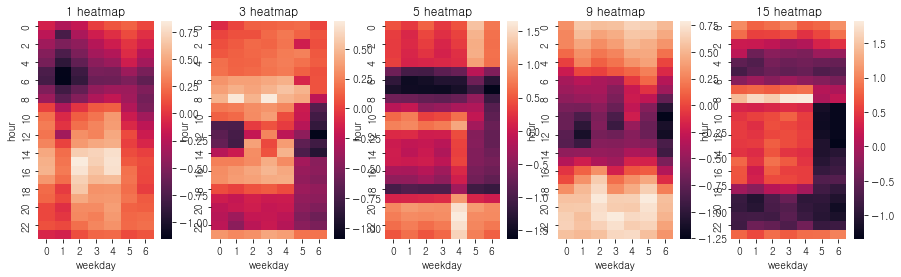

In [46]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

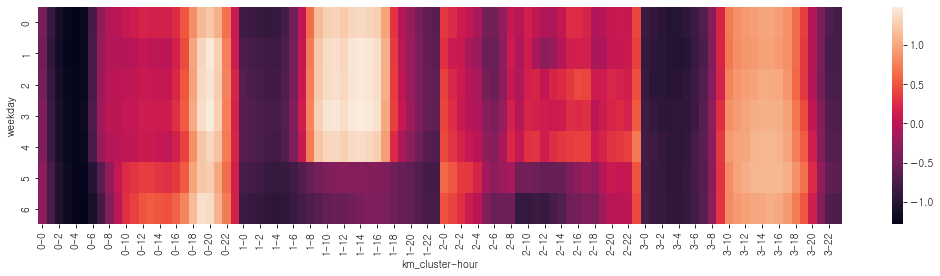

In [47]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

In [48]:
from scipy.stats import pearsonr

In [49]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)

In [50]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [51]:
cl_df['km_cluster'] = pred

In [52]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [53]:
corrs_temp = train_cl.groupby(['km_cluster', 'num'])['target'].mean().to_frame()

In [54]:
temp = train_cl.groupby(['num'])['cooler', 'solar'].max()

In [55]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['temp_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].humid,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['humid_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].sunny,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['sunny_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].wind,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['wind_corr'] = corrs

In [56]:
corrs_cl_temp = pd.merge(corrs_temp, temp, how='left', on='num').set_index(corrs_temp.index).round(2)

### 기온에 영향

In [57]:
corrs_temp_temp = (corrs_cl_temp.temp_corr
                   .reset_index()
                   .sort_values(by=['temp_corr'], ascending=False)
                  .set_index(['num'], drop=False))

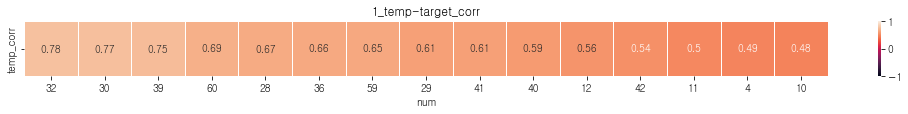

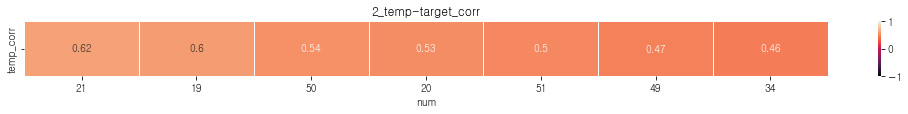

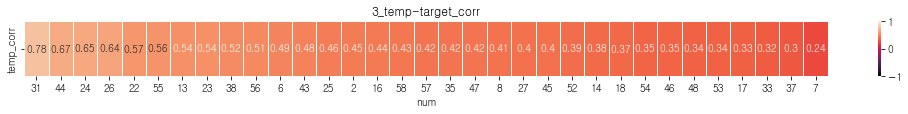

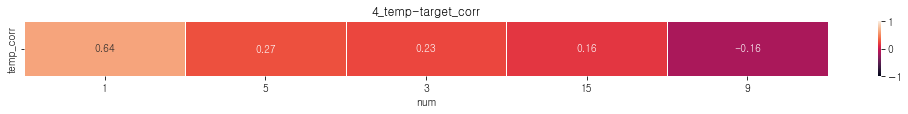

In [58]:
plt.figure(figsize=(18, 1))
plt.title('1_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('4_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

### 습도에 영향

In [59]:
corrs_temp_temp = (corrs_cl_temp.humid_corr
                   .reset_index()
                   .sort_values(by=['humid_corr'], ascending=True)
                  .set_index(['num'], drop=False))

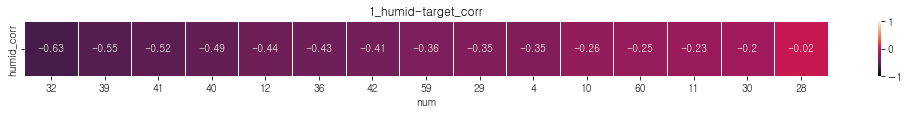

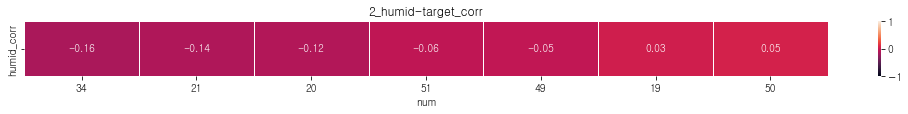

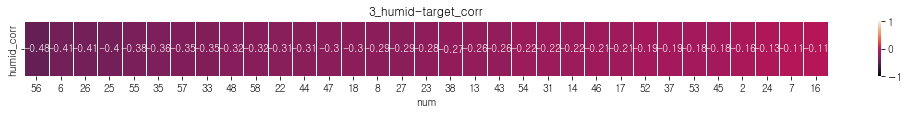

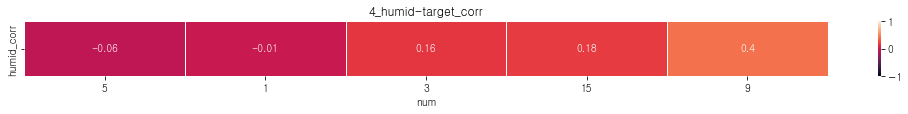

In [60]:
plt.figure(figsize=(18, 1))
plt.title('1_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('4_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

### 바람의 영향

In [61]:
corrs_temp_temp = (corrs_cl_temp.wind_corr
                   .reset_index()
                   .sort_values(by=['wind_corr'], ascending=False)
                  .set_index(['num'], drop=False))

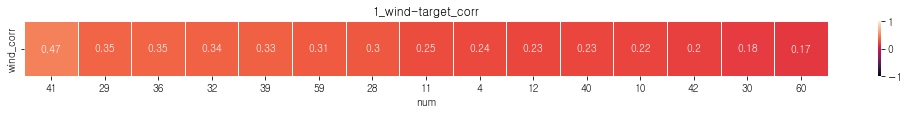

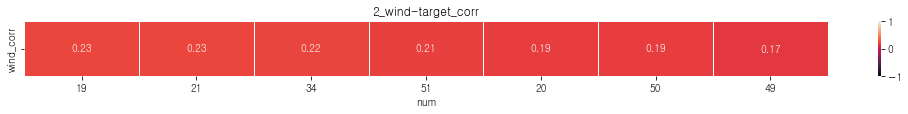

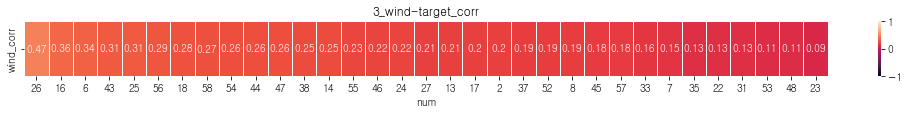

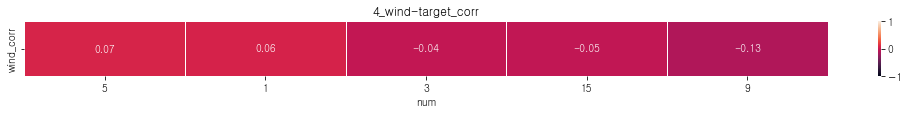

In [62]:
plt.figure(figsize=(18, 1))
plt.title('1_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('4_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()